### Cross validation over PHUS

We assume that all the observations from the stations within a PHU are more likely to estimate the behaviour of the PHU where they are.

The objective of this Notebook is to select the PHU's that have the best stations to estimate the behaviour of the PHU.

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from gee_scripts.parameters import explain_vars, regions_ids
from scipy.stats import pearsonr
from gee_scripts.models import get_regressors
import tensorflow as tf
from sklearn.discriminant_analysis import StandardScaler
from gee_scripts.models import split_dataset
import seaborn as sns


# 1. Read training data

In [7]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])

assert len(df) == 32783, "The length of the dataframe is not correct"

region = regions_ids["kalimantan"]
df = df[df.region_id.isin(region)]

assert df[["date"]].dtypes.iloc[0] == "datetime64[ns]"
len(df)

6063

<Axes: xlabel='date', ylabel='gwl_cm'>

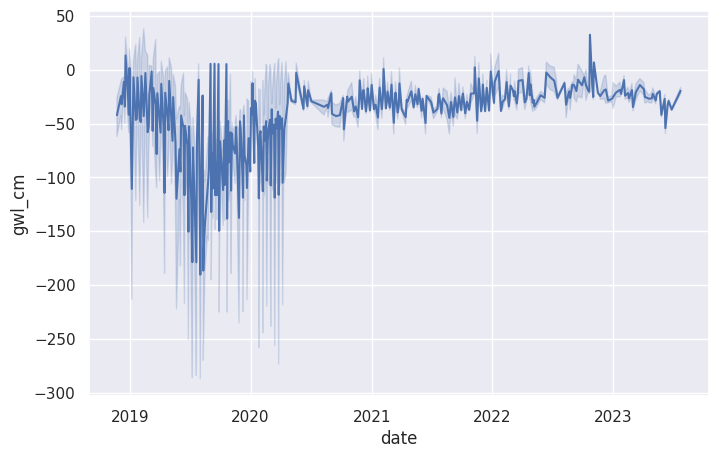

In [9]:
sns.lineplot(x="date", y="gwl_cm", data=df)

## Cros validation loop - PHU ranking

- Compare different ML algorithms: sradient boosting, random forest, simple neural network, linear model.<br>
- Assess performance across different temporal and spatial divisions of the data (train/test)<br>
- Get a distribution of performance metrics through the 10 random splits<br>

This comprehensive approach should give us a good understanding of how the models perform under different conditions and how generalizable they are.

<center><img src = "img/phu_ranking.jpg"/></center>

## Evaluation metrics
<p style="font-size:16px"><b>Pearson Correlation Coefficient (r)</b>: Measures the linear correlation between the true and predicted values. Values range from -1 to 1, where 1 indicates a perfect positive correlation.</br></br>
<b>R-squared Score</b>: Represents the proportion of the variance in the dependent variable that is predictable from the independent variables. Values range from 0 to 1, where 1 indicates that the model explains all the variance.</br></br>
<b>Root Mean Squared Error (RMSE)</b>: Measures the average magnitude of the prediction error. Lower values indicate better model performance.</br></br><p>

In [ ]:
def evaluate_models(data, target_column, n_splits):
    """Evaluate the performance of different regression models on the dataset using cross-validation."""

    data = data.copy()

    results = []
    
    # Loop through each split type
    for split_type in ["station", "year", "month"]:
        
        train_test_splits = split_dataset(data, by=split_type, n_splits=n_splits)

        if split_type == "station":
            split_type = "id"

        for train_data, test_data in train_test_splits:

            if len(test_data) == 0:
                results.append({
                    "phu_id": data["phu_id"].iloc[0],
                    "split_type": split_type,
                    "no_obs": len(data),
                    "train_obs": 0,
                    "test_obs": 0,
                    "estimator_name": None,
                    "validation" : f"cross validation {split_type}",
                    "test_ids": None,
                    "train_ids": None,
                    "r2_score": None,
                    "rmse": None,
                    "pearson_r": None,
                    "p_value": None,
                })
                continue
            
            X_train, X_test = train_data[explain_vars], test_data[explain_vars]
            y_train, y_test = train_data[target_column], test_data[target_column]

            input_dim = X_train.shape[1]  # Number of explanatory variables

            for regr in get_regressors(input_dim):
                print(f"Training {regr.__class__.__name__} on {len(train_data)} observations and testing on {len(test_data)} observations")

                if isinstance(regr, tf.keras.Model):  # Check if the model is a Keras model
                    # Neural network requires normalization and batch processing
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)
                    
                    # Fit the model
                    regr.fit(X_train_scaled, y_train, epochs=5, batch_size=8, verbose=0)
                    
                    # Predict
                    y_pred_test = regr.predict(X_test_scaled).flatten()  # Flatten to convert 2D predictions to 1D
                else:
                    # Fit traditional models
                    regr.fit(X_train, y_train)
                    
                    # Predict
                    y_pred_test = regr.predict(X_test)


                r, p = pearsonr(y_test, y_pred_test)
                r2_score_val = r2_score(y_test, y_pred_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

                results.append({
                    "phu_id": train_data["phu_id"].iloc[0],
                    "no_obs": len(data),
                    "train_obs": len(train_data),
                    "test_obs": len(test_data),
                    "estimator_name": regr.__class__.__name__,
                    "validation" : f"cross validation {split_type}",
                    "train_ids": train_data[split_type].unique(),
                    "test_ids": test_data[split_type].unique(),
                    "r2_score": r2_score_val,
                    "rmse": rmse,
                    "pearson_r": r,
                    "p_value": p,
                })

    return results

In [ ]:
sorted([(id_, len(df[df.phu_id == id_])) for id_ in df.phu_id.unique()], key=lambda x: x[0])

In [ ]:
%%time
phu_cross_validation_results = []
failed_phus = []
errors = {}

print(f"running cross validation on {df.phu_id.nunique()} phu_ids")

for phu_id in df.phu_id.unique():
    if  pd.isnull(phu_id):
        print("Skipping phu_id", phu_id, "because it is null")
        continue
    print("processing phu_id", phu_id, "with No. of observations", len(df[df.phu_id==phu_id]))
    filter_condition = df.phu_id==phu_id
    train_df = df[filter_condition]
    try:
        results = evaluate_models(train_df, "gwl_cm", n_splits=10)
        phu_cross_validation_results.extend(results)
    except exception as e:
        print("Failed to train model on phu_id", phu_id)
        errors[phu] = e
        failed_phus.append(phu_id)
    finally:
        continue

In [ ]:
# Create a dataframe from the results
results_df = pd.DataFrame(phu_cross_validation_results)
# Sort the results by r2_score and phu_id
results_df.sort_values(by=["r2_score", "phu_id"], ascending=False, inplace=True)
# results_df.to_csv("data/13_estimation_results/kalimantan_multiple_models_cross_validation_results_sorted.csv", index=False)

In [ ]:
results_df = pd.read_csv("data/13_estimation_results/center_multiple_models_cross_validation_results_sorted_2.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming phu_cross_validation_results is a list of dictionaries
results_df = pd.DataFrame(results_df)

# Summary statistics
summary_stats = results_df[['r2_score', 'rmse', 'pearson_r']].describe()

# Performance by model type
model_performance = results_df.groupby('estimator_name')[['r2_score', 'rmse', 'pearson_r']].mean()

# Plotting model performance
plt.figure(figsize=(12, 6))
sns.barplot(x='estimator_name', y='r2_score', data=results_df)
plt.title('Average R2 Score by Model Type')
plt.xticks(rotation=45)
plt.show()

# Analyze performance by split type
split_performance = results_df.groupby('split_type')[['r2_score', 'rmse', 'pearson_r']].mean()

# Print the summary statistics and model performance
print(summary_stats)
print(model_performance)
print(split_performance)

# Handle failures
print("Failed PHUs:", failed_phus)
